In [150]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly.plotly as py
#import plotly.graph_objs as go
#plotly.__version__
#plotly.tools.set_credentials_file(username='jordanvi', api_key='eWMeFHaplpUZvrjlAUZ9')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [151]:
from subprocess import check_output
print(check_output(["ls", "data/"]).decode("utf8"))

air_reserve.csv.zip
air_store_info.csv.zip
air_visit_data.csv.zip
date_info.csv.zip
hpg_reserve.csv.zip
hpg_store_info.csv.zip
sample_submission.csv.zip
store_id_relation.csv.zip



In [152]:
# Loading data
data = {
    'train': pd.read_csv('data/air_visit_data.csv.zip', compression="zip"),
    'air_store_info': pd.read_csv('data/air_store_info.csv.zip', compression="zip"),
    'hpg_store_info': pd.read_csv('data/hpg_store_info.csv.zip', compression="zip"),
    'air_reserve': pd.read_csv('data/air_reserve.csv.zip', compression="zip"),
    'hpg_reserve': pd.read_csv('data/hpg_reserve.csv.zip', compression="zip"),
    'store_id_relation': pd.read_csv('data/store_id_relation.csv.zip', compression="zip"),
    'test': pd.read_csv('data/sample_submission.csv.zip', compression="zip"),
    'date_info': pd.read_csv('data/date_info.csv.zip', compression="zip").rename(columns={'calendar_date':'visit_date'})
    }

In [153]:
data['hpg_reserve'].tail(5)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
2000315,hpg_2b293477ea4642fb,2017-05-31 20:00:00,2017-04-19 07:00:00,2
2000316,hpg_f922aeca48ca5a29,2017-05-31 20:00:00,2017-03-19 00:00:00,3
2000317,hpg_e9151de687b93aa3,2017-05-31 21:00:00,2017-04-14 20:00:00,49
2000318,hpg_fae6c96189b4a122,2017-05-31 21:00:00,2017-04-19 17:00:00,9
2000319,hpg_0b70de808b55ad1e,2017-05-31 23:00:00,2017-04-21 13:00:00,6


In [154]:
# bring air id to hpg reserve data
data['hpg_reserve'] = pd.merge(data['hpg_reserve'], data['store_id_relation'], how='inner', on=['hpg_store_id'])
# bring air id to hpg stores
data['hpg_store_info'] = pd.merge(data['hpg_store_info'], data['store_id_relation'], how='inner', on=['hpg_store_id'])

### Data Structure

In [155]:
print('Training data....',data['train'].shape)
print('Unique store id in training data',len(data['train']['air_store_id'].unique()))
print('Id data....',data['store_id_relation'].shape)
print('Air store data....',data['air_store_info'].shape,'& unique-',data['air_store_info']['air_store_id'].unique().shape)
print('Hpg store data....',data['hpg_store_info'].shape,'& unique-',data['hpg_store_info']['hpg_store_id'].unique().shape)
print('Air reserve data....',data['air_reserve'].shape,'& unique-',data['air_reserve']['air_store_id'].unique().shape)
print('Hpg reserve data....',data['hpg_reserve'].shape,'& unique-',data['hpg_reserve']['air_store_id'].unique().shape)

Training data.... (252108, 3)
Unique store id in training data 829
Id data.... (150, 2)
Air store data.... (829, 5) & unique- (829,)
Hpg store data.... (63, 6) & unique- (63,)
Air reserve data.... (92378, 4) & unique- (314,)
Hpg reserve data.... (28183, 5) & unique- (150,)


### Time Series of dataset

In [69]:
#converting datetime to date for reservation data
for df in ['air_reserve','hpg_reserve']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_hour'] = data[df]['visit_datetime'].dt.hour
    data[df]['visit_date'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_hour'] = data[df]['reserve_datetime'].dt.hour
    data[df]['reserve_date'] = data[df]['reserve_datetime'].dt.date
    
    data[df+'_hour'] = data[df]#keeping original
    
    #calculate reserve time difference and summarizing air_reserve,hpg_reserve to date
    data[df]['reserve_day_'+df] = data[df].apply(
        lambda r: (r['visit_date'] - r['reserve_date']).days, axis=1)
    data[df] = data[df].groupby(['air_store_id','visit_date'], as_index=False)[[
        'reserve_day_'+df, 'reserve_visitors']].sum().rename(columns={'reserve_visitors':'reserve_visitors_'+df})

In [70]:
#breaking down dates on training data & summarizing 
data['train']['visit_date'] = pd.to_datetime(data['train']['visit_date'])
data['train']['day'] = data['train']['visit_date'].dt.day
data['train']['dow'] = data['train']['visit_date'].dt.weekday
#data['train']['dow_name'] = data['train']['visit_date'].dt.weekday_name
data['train']['year'] = data['train']['visit_date'].dt.year
data['train']['month'] = data['train']['visit_date'].dt.month
data['train']['week'] = data['train']['visit_date'].dt.week
data['train']['quarter'] = data['train']['visit_date'].dt.quarter
data['train']['visit_date'] = data['train']['visit_date'].dt.date
data['train']['year_mth'] = data['train']['year'].astype(str)+'-'+data['train']['month'].astype(str)

In [71]:
#extracting store id and date info from test data
data['test']['air_store_id'] = data['test']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['test']['visit_date'] = data['test']['id'].map(lambda x: str(x).split('_')[2])
data['test']['visit_date'] = pd.to_datetime(data['test']['visit_date'])
data['test']['day'] = data['test']['visit_date'].dt.day
data['test']['dow'] = data['test']['visit_date'].dt.weekday
#data['test']['dow_name'] = data['test']['visit_date'].dt.weekday_name
data['test']['year'] = data['test']['visit_date'].dt.year
data['test']['month'] = data['test']['visit_date'].dt.month
data['test']['week'] = data['test']['visit_date'].dt.week
data['test']['quarter'] = data['test']['visit_date'].dt.quarter
data['test']['visit_date'] = data['test']['visit_date'].dt.date
data['test']['year_mth'] = data['test']['year'].astype(str)+'-'+data['test']['month'].astype(str)

In [72]:
print('Dates................')
print('train date- ,',data['train']['visit_date'].min(),' to ',data['train']['visit_date'].max())
print('test date - ,',data['test']['visit_date'].min(),' to ',data['test']['visit_date'].max())
print('holiday df- ,',data['date_info']['visit_date'].min(),' to ',data['date_info']['visit_date'].max())

Dates................
train date- , 2016-01-01  to  2017-04-22
test date - , 2017-04-23  to  2017-05-31
holiday df- , 2016-01-01  to  2017-05-31


In [73]:
data['train'].head(5)

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1,2016-1
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1,2016-1
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1,2016-1
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1,2016-1
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1,2016-1


In [74]:
data['test'] = data['test'].drop(['id'], axis=1)

In [75]:
data['train'].shape

(252108, 10)

In [76]:
data['test'].shape

(32019, 10)

In [77]:
list(data['train'])

['air_store_id',
 'visit_date',
 'visitors',
 'day',
 'dow',
 'year',
 'month',
 'week',
 'quarter',
 'year_mth']

In [78]:
list(data['test'])

['visitors',
 'air_store_id',
 'visit_date',
 'day',
 'dow',
 'year',
 'month',
 'week',
 'quarter',
 'year_mth']

## More explo

In [79]:
data['train'].tail(5)
# add season ?

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth
252103,air_24e8414b9b07decb,2017-04-18,6,18,1,2017,4,16,2,2017-4
252104,air_24e8414b9b07decb,2017-04-19,6,19,2,2017,4,16,2,2017-4
252105,air_24e8414b9b07decb,2017-04-20,7,20,3,2017,4,16,2,2017-4
252106,air_24e8414b9b07decb,2017-04-21,8,21,4,2017,4,16,2,2017-4
252107,air_24e8414b9b07decb,2017-04-22,5,22,5,2017,4,16,2,2017-4


In [80]:
data['test'].tail(5)

,visitors,air_store_id,visit_date,day,dow,year,month,week,quarter,year_mth
32014,0,air_fff68b929994bfbd,2017-05-27,27,5,2017,5,21,2,2017-5
32015,0,air_fff68b929994bfbd,2017-05-28,28,6,2017,5,21,2,2017-5
32016,0,air_fff68b929994bfbd,2017-05-29,29,0,2017,5,22,2,2017-5
32017,0,air_fff68b929994bfbd,2017-05-30,30,1,2017,5,22,2,2017-5
32018,0,air_fff68b929994bfbd,2017-05-31,31,2,2017,5,22,2,2017-5


In [81]:
#extract unique stores based on test data and populate dow 1 to 6
unique_stores = data['test']['air_store_id'].unique()#extract unique stores id from test data

store_7days = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) 
                    for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
store_sum = pd.DataFrame({'air_store_id': unique_stores})

In [82]:
store_7days.tail(5)

,air_store_id,dow
5742,air_fea5dc9594450608,6
5743,air_fee8dcf4d619598e,6
5744,air_fef9ccb3ba0da2f7,6
5745,air_ffcc2d5087e1b476,6
5746,air_fff68b929994bfbd,6


In [83]:
store_sum.tail(5)

,air_store_id
816,air_fea5dc9594450608
817,air_fee8dcf4d619598e
818,air_fef9ccb3ba0da2f7
819,air_ffcc2d5087e1b476
820,air_fff68b929994bfbd


In [84]:
data['train'].head(5)

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1,2016-1
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1,2016-1
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1,2016-1
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1,2016-1
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1,2016-1


In [85]:
# mapping train data dow to stores(test data) - min, mean, median, max, count 
tmp = data['train'].groupby(['air_store_id'], as_index=False)['visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 

tmp = data['test'].groupby(['air_store_id'], as_index=False)['visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

# map stores(test) to store genre and location detail
store_7days = pd.merge(store_7days, data['air_store_info'], how='left', on=['air_store_id']) 
#map to hpg genre and area
store_7days = pd.merge(store_7days, data['hpg_store_info'][['air_store_id','hpg_genre_name','hpg_area_name']], 
                       how='left', on=['air_store_id']) 

data['date_info']['visit_date'] = pd.to_datetime(data['date_info']['visit_date'])
data['date_info']['visit_date'] = data['date_info']['visit_date'].dt.date

hf=data['date_info']['holiday_flg']
dw=data['date_info']['day_of_week']
data['date_info']['long_wknd']=0

In [86]:
store_7days.shape

(5747, 18)

In [87]:
store_7days.tail(4)

,air_store_id,dow,total_visitors_x,total_visitors_y,mean_visitors_x,mean_visitors_y,median_visitors_x,median_visitors_y,max_visitors_x,max_visitors_y,count_observations_x,count_observations_y,air_genre_name,air_area_name,latitude,longitude,hpg_genre_name,hpg_area_name
5743,air_fee8dcf4d619598e,6,7496,0,30.200000,0,31.5,0,43.0,0,40.0,6,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,NaN,NaN
5744,air_fef9ccb3ba0da2f7,6,2357,0,10.634146,0,9.0,0,30.0,0,41.0,6,Japanese food,Hyōgo-ken Himeji-shi Yasuda,34.815149,134.685353,NaN,NaN
5745,air_ffcc2d5087e1b476,6,4919,0,4.250000,0,3.5,0,9.0,0,8.0,6,Izakaya,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN
5746,air_fff68b929994bfbd,6,1369,0,4.000000,0,3.5,0,10.0,0,30.0,6,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN


In [88]:
for i in range(len(data['date_info'])):
    if (hf[i]==1)&(dw[i]=='Friday'):
        data['date_info']['long_wknd'][i]=1
        data['date_info']['long_wknd'][i+1]=1
        data['date_info']['long_wknd'][i+2]=1
          
    if (hf[i]==1)&(dw[i]=='Monday'):
        data['date_info']['long_wknd'][i]=1
        data['date_info']['long_wknd'][i-1]=1
        data['date_info']['long_wknd'][i-2]=1

/Users/jordanvidal/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jordanvidal/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jordanvidal/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jordanvidal/python3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A valu

In [89]:
train = pd.merge(data['train'], data['date_info'], how='left', on=['visit_date']) 
test = pd.merge(data['test'], data['date_info'], how='left', on=['visit_date']) 
train = pd.merge(train, store_7days, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, store_7days, how='left', on=['air_store_id','dow'])

In [90]:
for df in ['air_reserve','hpg_reserve']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

In [91]:
train = train.fillna(0) #change to one for algo training
test = test.fillna(0)
train['v_no_reservation']=train['visitors']-train['reserve_visitors_air_reserve']-train['reserve_visitors_hpg_reserve']
test['v_no_reservation']=test['visitors']-test['reserve_visitors_air_reserve']-test['reserve_visitors_hpg_reserve']

In [92]:
train.shape

(252108, 34)

In [93]:
test.shape

(32019, 34)

### TEST GET DUMMIES

### 25/01

In [94]:
train3 = train.copy()
test3 = test.copy()

In [95]:
#train3[(train3['hpg_genre_name'] != 0)].head(5)

In [96]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#train3['air_store_id'] = le.fit_transform(train3['air_store_id'])
#test3['air_store_id'] = le.fit_transform(test3['air_store_id'])
le.fit(train3['air_store_id'])

LabelEncoder()

In [97]:
train3['air_store_id'] = le.transform(train3['air_store_id'])
test3['air_store_id'] = le.transform(test3['air_store_id'])

In [98]:
#train3[train3['air_genre_name'] == 0]

In [99]:
train3 = pd.get_dummies(data=train3, columns=['air_genre_name', 'air_area_name','hpg_genre_name','hpg_area_name'])
test3 = pd.get_dummies(data=test3, columns=['air_genre_name', 'air_area_name','hpg_genre_name','hpg_area_name'])

In [100]:
#val = train3['hpg_genre_name'].unique()
#print(len(val))

In [101]:
train3 = train3.drop(['visit_date','year_mth','day_of_week','air_genre_name_0','air_area_name_0'], axis=1)
test3 = test3.drop(['visit_date','year_mth','day_of_week'], axis=1)

### START MODELLING

In [104]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [105]:
y = train3.pop('visitors')

In [106]:
train3.shape

(252108, 194)

In [107]:
test3.shape

(32019, 195)

In [108]:
# split data into train and test sets
#seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(train3, y, test_size=test_size)

In [110]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [111]:
from sklearn import feature_selection

In [115]:
f = feature_selection.f_regression(X_train, y_train)

/Users/jordanvidal/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning:

invalid value encountered in true_divide

/Users/jordanvidal/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

/Users/jordanvidal/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

/Users/jordanvidal/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning:

invalid value encountered in less_equal



In [119]:
from sklearn.ensemble import RandomForestRegressor

In [121]:
rf = RandomForestRegressor()
model2 = rf.fit(X_train, y_train)
predictions2 = rf.predict(X_test)

In [128]:
importances = rf.feature_importances_

Feature ranking:
1. feature 25 (0.872109)
2. feature 22 (0.110706)
3. feature 24 (0.010381)
4. feature 15 (0.004390)
5. feature 13 (0.000553)
6. feature 21 (0.000263)
7. feature 23 (0.000255)
8. feature 11 (0.000181)
9. feature 0 (0.000146)
10. feature 27 (0.000124)
11. feature 2 (0.000113)
12. feature 17 (0.000096)
13. feature 9 (0.000077)
14. feature 19 (0.000076)
15. feature 1 (0.000063)
16. feature 29 (0.000046)
17. feature 5 (0.000045)
18. feature 4 (0.000036)
19. feature 18 (0.000031)
20. feature 20 (0.000028)
21. feature 146 (0.000022)
22. feature 58 (0.000017)
23. feature 8 (0.000017)
24. feature 33 (0.000016)
25. feature 143 (0.000012)
26. feature 3 (0.000012)
27. feature 169 (0.000011)
28. feature 6 (0.000011)
29. feature 83 (0.000010)
30. feature 164 (0.000008)
31. feature 160 (0.000008)
32. feature 168 (0.000007)
33. feature 7 (0.000007)
34. feature 77 (0.000007)
35. feature 186 (0.000007)
36. feature 153 (0.000006)
37. feature 117 (0.000005)
38. feature 32 (0.000005)
39. f

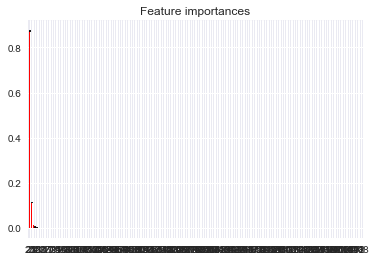

In [130]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [143]:
X_train.columns

Index(['air_store_id', 'day', 'dow', 'year', 'month', 'week', 'quarter', 'holiday_flg', 'long_wknd', 'total_visitors_x',
       ...
       'hpg_area_name_Tōkyō-to Machida-shi Nakamachi', 'hpg_area_name_Tōkyō-to Minato-ku Takanawa', 'hpg_area_name_Tōkyō-to Shibuya-ku Ebisunishi', 'hpg_area_name_Tōkyō-to Shibuya-ku None', 'hpg_area_name_Tōkyō-to Shinjuku-ku None', 'hpg_area_name_Tōkyō-to Shinjuku-ku Takadanobaba', 'hpg_area_name_Tōkyō-to Sumida-ku Tachibana', 'hpg_area_name_Tōkyō-to Taitō-ku None', 'hpg_area_name_Ōsaka-fu Ōsaka-shi Awajimachi', 'hpg_area_name_Ōsaka-fu Ōsaka-shi Shinsaibashisuji'], dtype='object', length=194)

In [52]:
predictions[0:10]

array([ 30.,   2.,  40.,   7.,   9.,  13.,  11.,  13.,  19.,  71.])

In [55]:
print(type(y_test))

<class 'pandas.core.series.Series'>


In [56]:
print(type(predictions))

<class 'numpy.ndarray'>


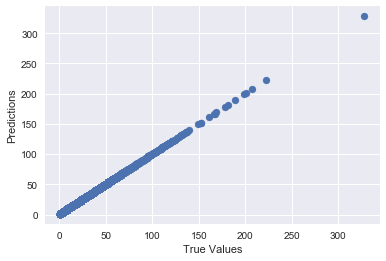

In [53]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [ ]:
print('Score:', model.score(X_test, y_test))

In [60]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(np.array(y_test), predictions))

1.40848213044e-12


In [ ]:
#accuracy_score(y_true, y_pred)

In [192]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression()

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.0000 +/-0.0000


In [193]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train3, y, test_size=0.2, random_state=0)

In [194]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

#X, y = make_classification(n_samples=1000, n_features=4,n_informative=2, n_redundant=0,random_state=0, shuffle=False)
#X = train3.drop("visitors", axis=1)
#y = test["visitors"]
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [196]:
clf.predict(X)

array([10, 10, 20, ...,  6,  6,  6])

In [198]:
print(clf.feature_importances_)

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   6.41140158e-04
   5.83821388e-05   1.17411307e-01   0.00000000e+00   5.57728988e-02
   0.00000000e+00   1.30033236e-01   0.00000000e+00   6.47610760e-02
   0.00000000e+00   0.00000000e+00   8.57469336e-03   6.12324432e-04
   0.00000000e+00   1.37999849e-01   3.34409428e-03   0.00000000e+00
   0.00000000e+00   2.49428044e-01   0.00000000e+00   8.80952403e-02
   0.00000000e+00   0.00000000e+00   5.28570420e-03   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.30931854e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

In [149]:
X_test['reserve_visitors_hpg_reserve']

144064     0.0
51992      0.0
218318     0.0
84866      0.0
160852     0.0
38820      0.0
157311     4.0
142927     0.0
24316      0.0
246729     0.0
149393     0.0
42959      0.0
204391     0.0
134426     0.0
61638      0.0
134343     0.0
107389     0.0
85338      0.0
239679     0.0
167024     0.0
105680     0.0
86118      0.0
211327     0.0
88234      0.0
17374      0.0
179395     0.0
17012      0.0
239707     0.0
126470     0.0
106291     0.0
107310     0.0
116300     0.0
770        0.0
191385     0.0
118003     0.0
183575     0.0
58156      0.0
145314     0.0
65738      0.0
198561     0.0
5879       0.0
99739      0.0
22698      0.0
69921      0.0
141704     0.0
19599     10.0
4871       0.0
155572     0.0
82967      0.0
117740     0.0
183730     0.0
151010     0.0
33615      2.0
87100      0.0
99199      0.0
46965      0.0
180206     0.0
54001      0.0
160641     0.0
169717     0.0
121847     0.0
19754      0.0
196946     0.0
50335      0.0
237538     0.0
111589     0.0
82522     

In [145]:
X_test.head(5)

,air_store_id,day,dow,year,month,week,quarter,holiday_flg,long_wknd,total_visitors_x,total_visitors_y,mean_visitors_x,mean_visitors_y,median_visitors_x,median_visitors_y,max_visitors_x,max_visitors_y,count_observations_x,count_observations_y,latitude,longitude,reserve_day_air_reserve,reserve_visitors_air_reserve,reserve_day_hpg_reserve,reserve_visitors_hpg_reserve,v_no_reservation,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food,air_area_name_Fukuoka-ken Fukuoka-shi Daimyō,air_area_name_Fukuoka-ken Fukuoka-shi Hakata Ekimae,air_area_name_Fukuoka-ken Fukuoka-shi Imaizumi,air_area_name_Fukuoka-ken Fukuoka-shi Momochi,air_area_name_Fukuoka-ken Fukuoka-shi Shiobaru,air_area_name_Fukuoka-ken Fukuoka-shi Takatori,air_area_name_Fukuoka-ken Fukuoka-shi Tenjin,air_area_name_Fukuoka-ken Fukuoka-shi Torikai,air_area_name_Fukuoka-ken Itoshima-shi Maebarunishi,air_area_name_Fukuoka-ken Kitakyūshū-shi Konyamachi,air_area_name_Fukuoka-ken Kitakyūshū-shi None,air_area_name_Fukuoka-ken Kitakyūshū-shi Ōtemachi,air_area_name_Fukuoka-ken Kurume-shi Jōnanmachi,air_area_name_Fukuoka-ken Yame-shi Motomachi,air_area_name_Hiroshima-ken Fukuyama-shi Higashisakuramachi,air_area_name_Hiroshima-ken Hiroshima-shi Kokutaijimachi,air_area_name_Hiroshima-ken Hiroshima-shi Nagarekawachō,air_area_name_Hokkaidō Abashiri-shi Minami 6 Jōhigashi,air_area_name_Hokkaidō Asahikawa-shi 6 Jōdōri,air_area_name_Hokkaidō Katō-gun Motomachi,air_area_name_Hokkaidō Sapporo-shi Atsubetsuchūō 1 Jō,air_area_name_Hokkaidō Sapporo-shi Kita 24 Jōnishi,air_area_name_Hokkaidō Sapporo-shi Kotoni 2 Jō,air_area_name_Hokkaidō Sapporo-shi Minami 3 Jōnishi,air_area_name_Hyōgo-ken Amagasaki-shi Higashinanamatsuchō,air_area_name_Hyōgo-ken Himeji-shi Yasuda,air_area_name_Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,air_area_name_Hyōgo-ken Kōbe-shi Kumoidōri,air_area_name_Hyōgo-ken Kōbe-shi Motomachidōri,air_area_name_Hyōgo-ken Kōbe-shi Sumiyoshi Higashimachi,air_area_name_Hyōgo-ken Nishinomiya-shi Rokutanjichō,air_area_name_Hyōgo-ken Takarazuka-shi Tōyōchō,air_area_name_Miyagi-ken Sendai-shi Kamisugi,air_area_name_Niigata-ken Kashiwazaki-shi Chūōchō,air_area_name_Niigata-ken Nagaoka-shi Ōtedōri,air_area_name_Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,air_area_name_Niigata-ken Niigata-shi Teraohigashi,air_area_name_Shizuoka-ken Hamamatsu-shi Motoshirochō,air_area_name_Shizuoka-ken Numazu-shi Miyukichō,air_area_name_Shizuoka-ken Shizuoka-shi Ōtemachi,air_area_name_Tōkyō-to Adachi-ku Chūōhonchō,air_area_name_Tōkyō-to Bunkyō-ku Kasuga,air_area_name_Tōkyō-to Bunkyō-ku Sendagi,air_area_name_Tōkyō-to Chiyoda-ku Kanda Jinbōchō,air_area_name_Tōkyō-to Chiyoda-ku Kudanminami,air_area_name_Tōkyō-to Chūō-ku Ginza,air_area_name_Tōkyō-to Chūō-ku Tsukiji,air_area_name_Tōkyō-to Edogawa-ku Chūō,air_area_name_Tōkyō-to Fuchū-shi Miyanishichō,air_area_name_Tōkyō-to Itabashi-ku Itabashi,air_area_name_Tōkyō-to Katsushika-ku Tateishi,air_area_name_Tōkyō-to Kita-ku Ōjihonchō,air_area_name_Tōkyō-to Koganei-shi Honchō,air_area_name_Tōkyō-to Kōtō-ku Kameido,air_area_name_Tōkyō-to Kōtō-ku Tomioka,air_area_name_Tōkyō-to Kōtō-ku Tōyō,air_area_name_Tōkyō-to Machida-shi Morino,air_area_name_Tōkyō-to Meguro-ku Jiyūgaoka,air_area_name_Tōkyō-to Meguro-ku Kamimeguro,air_area_name_Tōkyō-to Meguro-ku Takaban,air_area_name_Tōkyō-to Minato-ku Akasaka,air_area_name_Tōkyō-to Minato-ku Roppongi,air_area_name_Tōkyō-to Minato-ku Shibakōen,air_area_name_Tōkyō-to Musashino-shi Kichijōji Honchō,air_area_name_Tōkyō-to Musashino-shi Midorichō,air_area_name_Tōkyō-to Nakano-ku Nakano,air_area_name_Tōkyō-to Nerima-ku Toyotamakita,air_area_name_Tōkyō-to Setagaya-ku Kitazawa,air_area_name_

In [202]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

ModuleNotFoundError: No module named 'xgboost'

In [199]:
%%time
reg = XGBRegressor(max_depth=15, learning_rate=0.02, n_estimators=500,subsample=0.8, colsample_bytree=1, min_child_weight=5)
#self.clf = LGBMRegressor(max_depth=11, learning_rate=0.08, n_estimators=5000, num_leaves=40)
scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

NameError: name 'XGBRegressor' is not defined